Bu çalışma Tez çalışmanda deneyini yaptığım bir kaç senaryodan bir tanesidir.

Çalışmada - Savasy tarafından daha önce build edilen duygu sınıflandırıcısı modelinin öğrenme ağırlıkları davranış değişimi verisi ile güncellenerek Transfer Learning uygulanmıştır.

Ayrıca bu çalışmayı özgün kılan bir diğer yaklaşım ise, tamamı İngilizce olan verilerden Türkçe için de anlamlı çalışmalar yapılabilmesi için önce tüm İngilizce verinin TÜrkçeye çevrilmesi ve daha sonra verideki dengesizliklerin giderilmesi için back translation yöntemi ile veri arttırılmasıdır.



---

This study is one of the few scenarios I have experimented with in my thesis.

In the study - Transfer Learning was applied by updating the learning weights of the emotion classifier model previously built by Savasy with the behavioral change data.

Another approach that makes this study unique is that, in order to be able to conduct meaningful studies for Turkish from the data that is completely English, first all the English data is translated into Turkish and then the data is augmented with the back translation method to eliminate the imbalances in the data.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 21 11:59:01 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [ ]:
train_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/balanced_train_dataset.xlsx')
val_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/val_dataset.xlsx')
test_data = pd.read_excel('/content/drive/MyDrive/model/verisetleri/test_dataset.xlsx')

In [ ]:
train_data.head()

,text,label
0,evet. [SEP] onlara ödeme yapmanın bir yolu ve,change
1,mmhmm. yani yardımcı oldu [SEP] evet. kendimi ...,sustain
2,"ve aynı zamanda, geçmişi bırakmak zor, ama öte...",change
3,tamam. [SEP] evet. sanırım bunu yapabilirim. ş...,change
4,"şey, ve biliyorum ki bazı müşteriler özgürlükl...",change


In [ ]:
val_data.head()

,text,label
0,evet. [SEP] o ragbi ve kriket aslında aynıydı.,neutral
1,"ve böylece, bunu yapmamak sizin için daha kola...",neutral
2,"hayır, hayır. bu kolay olacak. peki senin için...",change
3,"ve bu biraz korkutucu. [SEP] aman tanrım, evet...",neutral
4,ve ayrıca içtiğinizde bazen bazı şeyleri unutt...,neutral


In [ ]:
test_data.head()

,text,label
0,"hıhı, hıhı. [SEP] eee.",neutral
1,tamam. peki senin için nasıl bir şey? [SEP] be...,neutral
2,"öyleyse, yanına gidip, hey, mcdonalds patates ...",neutral
3,evet. [SEP] işte ben de bunu yapmak istiyorum.,change
4,"evet. [SEP] tamam, anladın işte.",neutral


In [ ]:
train_data.shape, val_data.shape, test_data.shape

((5214, 2), (706, 2), (706, 2))

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Önceden eğitilmiş duygu analizi modelini yükleyin
model_name = "savasy/bert-base-turkish-sentiment-cased"  # Duygu analizi modeli
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,
                                                           ignore_mismatched_sizes=True)

# Sınıf etiketlerini özelleştirin
model.config.id2label = {0: "change", 1: "sustain", 2: "neutral"}
model.config.label2id = {"change": 0, "sustain": 1, "neutral": 2}

# Dropout oranlarını ayarlayın
model.config.hidden_dropout_prob = 0.2  # Varsayılan 0.1'dir, bunu artırıyoruz
model.config.attention_probs_dropout_prob = 0.2  # Varsayılan 0.1'dir, bunu artırıyoruz

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stre

In [ ]:
'''

# Modelin çıkış sınıflarını 3'e uyarlayın
model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                           num_labels=3,
                                                           ignore_mismatched_sizes=True)

# Sınıf etiketlerini özelleştirin
model.config.id2label = {0: "change", 1: "sustain", 2: "neutral"}
model.config.label2id = {"change": 0, "sustain": 1, "neutral": 2}
'''

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([3]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([3, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import torch
# If you have a GPU, you can try forcing the model to use it (or a specific one) like this:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use your desired GPU if you have multiple.
    model = model.to(device)
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    model = model.to(device)
    print("Using CPU")

Using GPU: Tesla T4


In [ ]:
"""# Eğitim, doğrulama ve test setlerine ayırın
from sklearn.model_selection import train_test_split

train_texts, remaining_texts, train_labels, remaining_labels = train_test_split(
    data_4["terapist_danisan"],
    data_4["label"],
    test_size=0.3,
    random_state=42
)

# Remaining data is further split into validation and test sets
val_texts, test_texts, val_labels, test_labels = train_test_split(
    remaining_texts,
    remaining_labels,
    test_size=0.5,
    random_state=42
)

"""

In [ ]:
!pip install datasets

In [ ]:
from datasets import Dataset

In [ ]:
# label_mapping sözlüğünü tanımla
label_mapping = {"change": 0, "sustain": 1, "neutral": 2}

# train_data'yı Dataset nesnesine dönüştür
train_dataset = Dataset.from_pandas(train_data)

# val_data'yı Dataset nesnesine dönüştür
val_dataset = Dataset.from_pandas(val_data)

# test_data'yı Dataset nesnesine dönüştür
test_dataset = Dataset.from_pandas(test_data)

# Her bir veri kümesindeki 'label' sütununu eşle
train_dataset = train_dataset.map(lambda example: {'label': label_mapping[example['label']]})
val_dataset = val_dataset.map(lambda example: {'label': label_mapping[example['label']]})
test_dataset = test_dataset.map(lambda example: {'label': label_mapping[example['label']]})

Map:   0%|          | 0/5214 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

In [ ]:
sample = train_dataset.take(5)
df = sample.to_pandas()
display(df)

,text,label
0,evet. [SEP] onlara ödeme yapmanın bir yolu ve,0
1,mmhmm. yani yardımcı oldu [SEP] evet. kendimi ...,1
2,"ve aynı zamanda, geçmişi bırakmak zor, ama öte...",0
3,tamam. [SEP] evet. sanırım bunu yapabilirim. ş...,0
4,"şey, ve biliyorum ki bazı müşteriler özgürlükl...",0


In [ ]:
# Tokenizasyon
def tokenize_function(examples):
    # Make sure input data is padded on the CPU before moving to the GPU
    inputs = tokenizer(examples["text"], padding="longest", truncation=True, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()} # Now move to GPU after padding
    return inputs

In [ ]:
train_tokenized = train_dataset.map(tokenize_function, batched=True)
val_tokenized = val_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/5214 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

Map:   0%|          | 0/706 [00:00<?, ? examples/s]

In [ ]:
'''from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model/results_2",
    evaluation_strategy="epoch",  # Changed to "epoch" to match save_strategy
    learning_rate=1e-5,
    save_steps=500,            # Can be kept as is if you want intermediate saves
    eval_steps=500,            # Now redundant but won't cause issues
    per_device_train_batch_size=16,
    num_train_epochs=10,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False  # Daha düşük kayıp daha iyi
)

'''

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization",
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    save_steps=500,            # Can be kept as is if you want intermediate saves
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=25,
    weight_decay=0.05,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1", #değiştirmeyi unutma
    greater_is_better=True, #değiştirmeyi unutma
    fp16=True,  # Enable mixed precision training if your GPU supports it
    gradient_accumulation_steps=1,  # Accumulate gradients over multiple steps
    # **Mitigating Algorithmic Bias**
    seed=42, # Set a random seed for reproducibility
    # Consider adding more data augmentation or bias-aware fine-tuning techniques if applicable to your dataset.
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install evaluate

In [ ]:
from datasets import load_dataset # This is for loading datasets
from evaluate import load # This is for loading metrics

In [ ]:
#from datasets import load_metric # This line is replaced

# Metrikleri yükleyin
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

# Değerlendirme fonksiyonunu tanımlayın
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    print(f"Logits shape: {logits.shape}") # Print logits shape
    print(f"Labels shape: {labels.shape}") # Print labels shape
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    precision = precision_metric.compute(predictions=predictions, references=labels, average="weighted")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="weighted")
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42) # 5 katlı çapraz doğrulama

In [ ]:
best_model_path = "/content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization/model_back_translation_oversampling_duygu_tf_cv_5_dinamik"  # En iyi modelin kaydedileceği yol

In [ ]:
from collections import defaultdict
from transformers import EarlyStoppingCallback, TrainingArguments, Trainer


In [ ]:
# from transformers import AdamW

In [ ]:
#optimizer = AdamW(model.parameters(), lr= 1e-5)

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
best_epochs = []
fold_metrics = defaultdict(dict)

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):
    print(f"Fold {fold}")
    train_fold = train_dataset.select(train_ids)
    val_fold = train_dataset.select(val_ids)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_fold.map(tokenize_function, batched=True), # train_fold kullanın
        eval_dataset=val_fold.map(tokenize_function, batched=True),  # val_fold kullanın
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=5)],
        #optimizers=(optimizer, None)

    )

    train_results = trainer.train()
    best_epochs.append(int(train_results.metrics["epoch"]))  # En iyi epoch'u kaydedin (int olarak)

    # Get evaluation metrics (including eval_loss) using evaluate()
    eval_results = trainer.evaluate() # Evaluate to get eval_loss
    metrics = eval_results
    #predictions = trainer.predict(val_fold.map(tokenize_function, batched=True)) # This line is no longer needed.
    #metrics = compute_metrics((predictions.predictions, predictions.label_ids)) # This is also not needed.

    print(f"Fold {fold} metrics: {metrics}")

    for metric_name, metric_value in metrics.items():
        fold_metrics[fold][metric_name] = metric_value

    # En iyi modeli kaydet
    if fold == 0 or metrics["eval_loss"] < best_loss:  # Now you can access eval_loss
        best_loss = metrics["eval_loss"]
        trainer.save_model(best_model_path)
        print(f"En iyi model Fold {fold} için kaydedildi.")

print("En iyi model:", best_model_path)
print("Her katın en iyi epoch'ları:", best_epochs)

metrics_df = pd.DataFrame.from_dict(fold_metrics, orient='index')
print(metrics_df)

Fold 0


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Currently logged in as: hcanbarutcu (hcanbarutcu-istanbul-university). Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.773673,0.674976,0.674114,0.674976,0.674407
2,0.820000,0.666410,0.713327,0.722732,0.713327,0.710897
3,0.820000,0.608562,0.771812,0.790235,0.771812,0.770313
4,0.423100,0.541246,0.800575,0.799878,0.800575,0.799229
5,0.423100,0.685026,0.799616,0.819562,0.799616,0.794061
6,0.178200,0.669629,0.828380,0.834543,0.828380,0.827464
7,0.178200,0.756079,0.824545,0.830879,0.824545,0.822312
8,0.083200,0.797932,0.835091,0.837876,0.835091,0.833959
9,0.083200,0.825325,0.846596,0.846487,0.846596,0.845735
10,0.048000,0.908710,0.843720,0.843570,0.843720,0.842800


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 0 metrics: {'eval_loss': 0.8709537386894226, 'eval_accuracy': 0.8465963566634708, 'eval_precision': 0.8487173073510117, 'eval_recall': 0.8465963566634708, 'eval_f1': 0.8460392331579184, 'eval_runtime': 4.7409, 'eval_samples_per_second': 220.0, 'eval_steps_per_second': 13.921, 'epoch': 16.0}
En iyi model Fold 0 için kaydedildi.
Fold 1


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.030890,0.988495,0.988584,0.988495,0.988484
2,0.178900,0.036757,0.990412,0.990490,0.990412,0.990384
3,0.178900,0.047109,0.984660,0.984801,0.984660,0.984694
4,0.058500,0.028147,0.991371,0.991391,0.991371,0.991355
5,0.058500,0.033566,0.991371,0.991391,0.991371,0.991355
6,0.038800,0.033906,0.991371,0.991433,0.991371,0.991349
7,0.038800,0.029759,0.991371,0.991391,0.991371,0.991355
8,0.030900,0.033766,0.990412,0.990418,0.990412,0.990398
9,0.030900,0.033331,0.991371,0.991371,0.991371,0.991362
10,0.025300,0.037054,0.988495,0.988517,0.988495,0.988479


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 1 metrics: {'eval_loss': 0.03333102911710739, 'eval_accuracy': 0.9913710450623202, 'eval_precision': 0.9913709081396251, 'eval_recall': 0.9913710450623202, 'eval_f1': 0.991361662606138, 'eval_runtime': 4.7456, 'eval_samples_per_second': 219.783, 'eval_steps_per_second': 13.908, 'epoch': 14.0}
En iyi model Fold 1 için kaydedildi.
Fold 2


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.040436,0.987536,0.987531,0.987536,0.987532
2,0.041700,0.025112,0.993289,0.993333,0.993289,0.993286
3,0.041700,0.034284,0.991371,0.991405,0.991371,0.991376
4,0.042600,0.036522,0.992330,0.992356,0.992330,0.992328
5,0.042600,0.024149,0.992330,0.992394,0.992330,0.992323
6,0.030900,0.024213,0.992330,0.992366,0.992330,0.992320
7,0.030900,0.020526,0.993289,0.993329,0.993289,0.993282


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 2 metrics: {'eval_loss': 0.025112152099609375, 'eval_accuracy': 0.9932885906040269, 'eval_precision': 0.9933327401815604, 'eval_recall': 0.9932885906040269, 'eval_f1': 0.9932864950950782, 'eval_runtime': 4.3598, 'eval_samples_per_second': 239.229, 'eval_steps_per_second': 15.138, 'epoch': 7.0}
En iyi model Fold 2 için kaydedildi.
Fold 3


Map:   0%|          | 0/4171 [00:00<?, ? examples/s]

Map:   0%|          | 0/1043 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.023097,0.991371,0.991373,0.991371,0.991361
2,0.036500,0.036136,0.990412,0.990448,0.990412,0.990416
3,0.036500,0.030230,0.991371,0.991390,0.991371,0.991374
4,0.037900,0.039141,0.990412,0.990448,0.990412,0.990416
5,0.037900,0.031739,0.991371,0.991393,0.991371,0.991371
6,0.029600,0.041031,0.990412,0.990433,0.990412,0.990411
7,0.029600,0.035958,0.991371,0.991393,0.991371,0.991371
8,0.021900,0.028713,0.991371,0.991393,0.991371,0.991371


Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)
Logits shape: (1043, 3)
Labels shape: (1043,)


Logits shape: (1043, 3)
Labels shape: (1043,)
Fold 3 metrics: {'eval_loss': 0.0302297230809927, 'eval_accuracy': 0.9913710450623202, 'eval_precision': 0.991389709188127, 'eval_recall': 0.9913710450623202, 'eval_f1': 0.9913741754577946, 'eval_runtime': 4.4752, 'eval_samples_per_second': 233.063, 'eval_steps_per_second': 14.748, 'epoch': 8.0}
Fold 4


Map:   0%|          | 0/4172 [00:00<?, ? examples/s]

Map:   0%|          | 0/1042 [00:00<?, ? examples/s]

<ipython-input-26-82b34bb99a99>:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.026320,0.992322,0.992367,0.992322,0.992323
2,0.038400,0.023400,0.992322,0.992367,0.992322,0.992323
3,0.038400,0.027160,0.992322,0.992334,0.992322,0.992323
4,0.029100,0.024993,0.994242,0.994283,0.994242,0.994246
5,0.029100,0.030115,0.992322,0.992377,0.992322,0.992321
6,0.022700,0.027605,0.993282,0.993321,0.993282,0.993285
7,0.022700,0.034296,0.991363,0.991373,0.991363,0.991364
8,0.022000,0.025765,0.994242,0.994283,0.994242,0.994246
9,0.022000,0.023183,0.992322,0.992367,0.992322,0.992323


Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)
Logits shape: (1042, 3)
Labels shape: (1042,)


Logits shape: (1042, 3)
Labels shape: (1042,)
Fold 4 metrics: {'eval_loss': 0.024992551654577255, 'eval_accuracy': 0.9942418426103646, 'eval_precision': 0.9942834162347285, 'eval_recall': 0.9942418426103646, 'eval_f1': 0.9942460242213019, 'eval_runtime': 4.442, 'eval_samples_per_second': 234.579, 'eval_steps_per_second': 14.858, 'epoch': 9.0}
En iyi model Fold 4 için kaydedildi.
En iyi model: /content/drive/MyDrive/model/back_translation_oversampling_duygu_transfer_dinamik_tokenization/model_back_translation_oversampling_duygu_tf_cv_5_dinamik
Her katın en iyi epoch'ları: [16, 14, 7, 8, 9]
   eval_loss  eval_accuracy  eval_precision  eval_recall   eval_f1  \
0   0.870954       0.846596        0.848717     0.846596  0.846039   
1   0.033331       0.991371        0.991371     0.991371  0.991362   
2   0.025112       0.993289        0.993333     0.993289  0.993286   
3   0.030230       0.991371        0.991390     0.991371  0.991374   
4   0.024993       0.994242        0.994283     0.9942

In [ ]:
'''
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=val_tokenized, # Add this line to provide the evaluation dataset
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

'''

<ipython-input-19-b3ae9fb9b5db>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
'''
# Modeli eğit
trainer.train()
'''

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.698814,0.710884,0.677400,0.710884,0.662887
2,No log,0.703103,0.698980,0.707062,0.698980,0.701970
3,0.743700,0.681757,0.731293,0.718820,0.731293,0.718483
4,0.743700,0.784528,0.695578,0.713071,0.695578,0.699015
5,0.458500,0.859881,0.709184,0.706764,0.709184,0.706597
6,0.458500,1.034860,0.722789,0.720509,0.722789,0.713906
7,0.194200,1.200123,0.724490,0.713871,0.724490,0.711583
8,0.194200,1.385365,0.719388,0.706031,0.719388,0.711242
9,0.194200,1.621050,0.693878,0.709572,0.693878,0.697759
10,0.089500,1.672031,0.688776,0.702235,0.688776,0.694242


Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels shape: (588,)
Logits shape: (588, 3)
Labels sh

TrainOutput(global_step=11050, training_loss=0.0887444714615248, metrics={'train_runtime': 2487.7326, 'train_samples_per_second': 70.908, 'train_steps_per_second': 4.442, 'total_flos': 2.374884730836979e+16, 'train_loss': 0.0887444714615248, 'epoch': 50.0})

In [ ]:
'''
metrics = trainer.evaluate()
print(metrics)

'''

Logits shape: (588, 3)
Labels shape: (588,)
{'eval_loss': 0.6817567944526672, 'eval_accuracy': 0.7312925170068028, 'eval_precision': 0.7188202143360436, 'eval_recall': 0.7312925170068028, 'eval_f1': 0.7184830856242643, 'eval_runtime': 2.4945, 'eval_samples_per_second': 235.721, 'eval_steps_per_second': 29.666, 'epoch': 50.0}


In [ ]:
# Tahminleri al
predictions = trainer.predict(test_tokenized) # Use the tokenized test dataset

# Logits (modelin çıktıları) ve gerçek etiketler
logits = predictions.predictions
true_labels = predictions.label_ids

# Tahmin edilen sınıflar
import numpy as np
predicted_labels = np.argmax(logits, axis=1)

Logits shape: (706, 3)
Labels shape: (706,)


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f"Accuracy: {round(accuracy,4)}")
print(f"Precision: {round(precision,4)}")
print(f"Recall: {round(recall,4)}")
print(f"F1 Score: {round(f1,4)}")

Accuracy: 0.6289
Precision: 0.6685
Recall: 0.6289
F1 Score: 0.6391


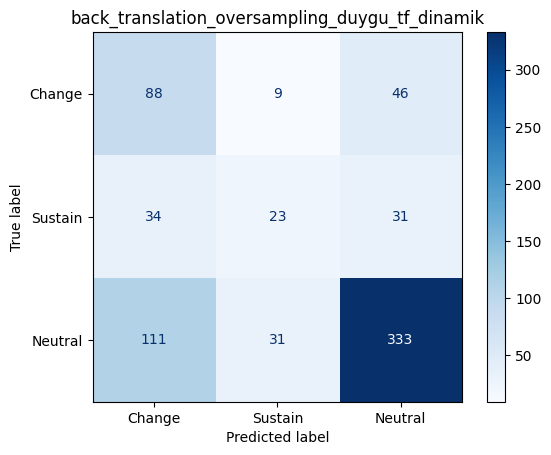

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Grafik oluştur
fig, ax = plt.subplots()

# Confusion matrix başlığı
ax.set_title("back_translation_oversampling_duygu_tf_dinamik")

# Karışıklık matrisini oluştur ve çizdir
conf_matrix = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Change", "Sustain", "Neutral"])
disp.plot(cmap="Blues", ax=ax)  # ax parametresi ile mevcut grafiği belirt


[[61.54  6.29 32.17]
 [38.64 26.14 35.23]
 [23.37  6.53 70.11]]


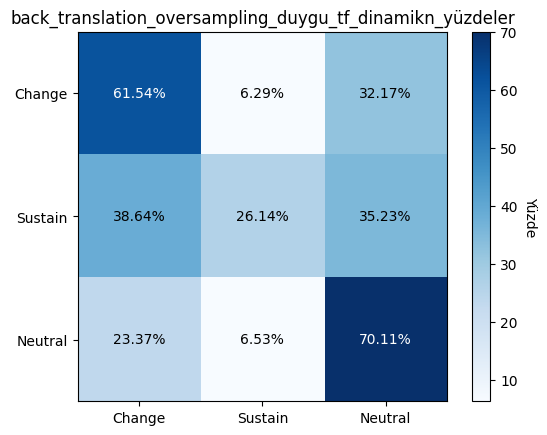

In [ ]:
# Her etiket için yüzdeleri hesapla
row_sums = conf_matrix.sum(axis=1, keepdims=True)  # Her satırın toplamını hesapla
conf_matrix_percent = np.round(conf_matrix / row_sums * 100, 2)  # Yüzdeleri elde etmek için böl


# Sonuçları yazdır
print(conf_matrix_percent)


# Grafik oluştur
fig, ax = plt.subplots()

# Heatmap oluştur
im = ax.imshow(conf_matrix_percent, cmap="Blues")

# Eksen etiketleri
ax.set_xticks(np.arange(conf_matrix_percent.shape[1]))
ax.set_yticks(np.arange(conf_matrix_percent.shape[0]))
ax.set_xticklabels(["Change", "Sustain", "Neutral"])
ax.set_yticklabels(["Change", "Sustain", "Neutral"])

# Hücre değerlerini göster
for i in range(conf_matrix_percent.shape[0]):
    for j in range(conf_matrix_percent.shape[1]):
        text = ax.text(j, i, f"{conf_matrix_percent[i, j]}%",
                       ha="center", va="center", color="white" if conf_matrix_percent[i, j] > 50 else "black")

# Renk çubuğu
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Yüzde", rotation=-90, va="bottom")

# Başlık
ax.set_title("back_translation_oversampling_duygu_tf_dinamikn_yüzdeler")

plt.show()

In [ ]:
metrics_df

,eval_loss,eval_accuracy,eval_precision,eval_recall,eval_f1,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch
0,0.870954,0.846596,0.848717,0.846596,0.846039,4.7409,220.000,13.921,16.0
1,0.033331,0.991371,0.991371,0.991371,0.991362,4.7456,219.783,13.908,14.0
2,0.025112,0.993289,0.993333,0.993289,0.993286,4.3598,239.229,15.138,7.0
3,0.030230,0.991371,0.991390,0.991371,0.991374,4.4752,233.063,14.748,8.0
4,0.024993,0.994242,0.994283,0.994242,0.994246,4.4420,234.579,14.858,9.0


In [ ]:
test_res = pd.DataFrame([[accuracy, precision, recall, f1]],
                        columns=['accuracy', 'precision', 'recall', 'f1'])
test_res

,accuracy,precision,recall,f1
0,0.628895,0.668454,0.628895,0.639096


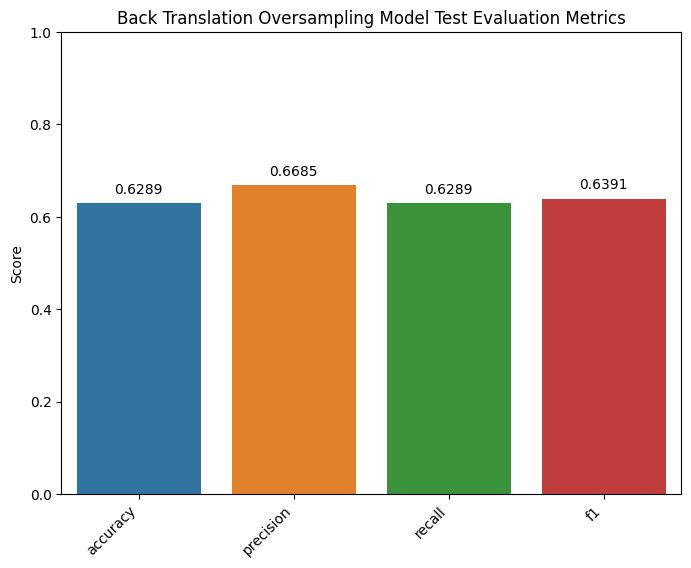

In [ ]:
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=test_res)  # Store the Axes object returned by sns.barplot
plt.title("Back Translation Oversampling Model Test Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")

# Add values on top of bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.4f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.show()